### **CMPE 257 Assignment 5 - Amalgmation, HPO, AutoML and Classification**
Market segmentation is important for small scale businesses to filter out their target markets. This can include segments of users whom they can target in order to increase sales, or segments of products that they can replace to increase their income.

**Objective function:** 
To classify the event_types into purchased or non purchased based on the historic user behaviour data shown above
**Dataset Number 1:** 
eCommerce customer behavior data

https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store




In [ ]:
# Uninstall mkl for faster neural-network training time
!pip uninstall -y mkl
# Upgrade pip to ensure the latest package versions are available
!pip install -U pip
# Upgrade setuptools to be compatible with namespace packages
!pip install -U setuptools
!pip install -U "mxnet<2.0.0"
# Install pre-release, frozen to a particual pre-release for stability
!pip install --pre "autogluon==0.0.16b20201214"
!pip install -U ipykernel

# **Data collection and preparation**

In [ ]:
#Importing data from google sheets
from io import BytesIO
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cluster import KMeans
import seaborn as sns
import tensorflow.compat.v1 as tf
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vTrfrhv1SOGSa0cLry-16Tx4ykJZBRDDjtCCJJzai0OtB8ewYbmzcSyNBSqvARAqHppa_NM1LH1-MEC/pub?gid=1654498000&single=true&output=csv')
data = r.content
df_Oct = pd.read_csv(BytesIO(data))
df_Oct = df_Oct.drop(columns='Unnamed: 0', axis=1)

In [ ]:
df_Oct.shape

(50000, 9)

In [ ]:
df_Oct.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-10-01 00:00:00 UTC,view,44600062,2103807459595387724,NaN,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c
1,2019-10-01 00:00:00 UTC,view,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc
2,2019-10-01 00:00:01 UTC,view,17200506,2053013559792632471,furniture.living_room.sofa,NaN,543.10,519107250,566511c2-e2e3-422b-b695-cf8e6e792ca8
3,2019-10-01 00:00:01 UTC,view,1307067,2053013558920217191,computers.notebook,lenovo,251.74,550050854,7c90fc70-0e80-4590-96f3-13c02c18c713
4,2019-10-01 00:00:04 UTC,view,1004237,2053013555631882655,electronics.smartphone,apple,1081.98,535871217,c6bd7419-2748-4c56-95b4-8cec9ff8b80d


# **Data wrangling**

In [ ]:
##Checking for null values in df
df_Oct.isnull().sum()

event_time           0
event_type           0
product_id           0
category_id          0
category_code    16098
brand             7041
price                0
user_id              0
user_session         0
dtype: int64

### **Column: category_code**

In [ ]:
##Replace all null values in the 'category_code' column
df_Oct.category_code = df_Oct.category_code.replace(np.nan,'Not Available')

### **Column: brand**

In [ ]:
##Replace all null values in the 'brand column'
df_Oct.brand = df_Oct.brand.replace(np.nan,'Not Available')

### **Column: event_time**

In [ ]:
##Converting the date type to datetime type for 'event_time'
df_Oct['event_time'] = pd.to_datetime(df_Oct['event_time'], format='%Y-%m-%d %H:%M:%S UTC')

In [ ]:
##Splitting event_time into 2 columns containing date and time respectively
df_Oct['transaction_time'] = df_Oct['event_time'].dt.time
df_Oct['transaction_date'] = df_Oct['event_time'].dt.normalize()

### **product_id**

In [ ]:
## Counting how many unique products are in the dataset
print('The total count for product id is:',df_Oct['product_id'].count())
print('The total unique count for product id is:',len(df_Oct['product_id'].unique()))

The total count for product id is: 50000
The total unique count for product id is: 13289


### **user_id**

In [ ]:
## Counting how many unique products are in the dataset
print('The total count for user id is:',df_Oct['user_id'].count())
print('The total unique count for user id is:',len(df_Oct['user_id'].unique()))

The total count for user id is: 50000
The total unique count for user id is: 10931


### **price**

In [ ]:
##using the describe method on column 'price' to ensure that there are no negative values
df_Oct['price'].describe()

count    50000.000000
mean       285.880781
std        361.302612
min          0.000000
25%         60.230000
50%        154.410000
75%        356.250000
max       2574.070000
Name: price, dtype: float64

### **event_type**

In [ ]:
df_Oct['event_type'].value_counts()

view        48676
purchase      748
cart          576
Name: event_type, dtype: int64

In [ ]:
##Ensure all the 'null' values are taken care of
df_Oct.isnull().sum()

event_time          0
event_type          0
product_id          0
category_id         0
category_code       0
brand               0
price               0
user_id             0
user_session        0
transaction_time    0
transaction_date    0
dtype: int64

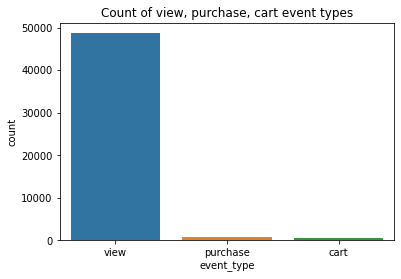

In [ ]:
##Count of event types
plt.title('Count of view, purchase, cart event types')
sns.countplot(x = 'event_type', data = df_Oct)

#**Preparation for running HPO without amalgamation**

In [ ]:
##Converting numeric to categoric data - 'event_type'
df_Oct['event_type'].replace({
    'view': 0,
    'cart': 0,
    'purchase': 1}, inplace = True
)

In [ ]:
df_Oct['event_type'].value_counts()

0    49252
1      748
Name: event_type, dtype: int64

In [ ]:
##creating two dataframes with purchased users and non purchased users to balance the data
purchased_set = df_Oct[df_Oct['event_type']==1]
non_purchased_set = df_Oct[df_Oct['event_type']==0]

In [ ]:
from sklearn.utils import resample
##equally sampling 150 data points from each type
n_samples = 150
puchased_sampled = resample(purchased_set, replace=False, n_samples=n_samples, random_state=27)
not_purchased_sampled = resample(non_purchased_set, replace=False, n_samples=n_samples, random_state=27)

In [ ]:
##creating a dataframe sampled by concatenating purchased and not purchased sampled dataframes
sampled = pd.concat([puchased_sampled, not_purchased_sampled])
sampled['event_type'].value_counts()

1    150
0    150
Name: event_type, dtype: int64

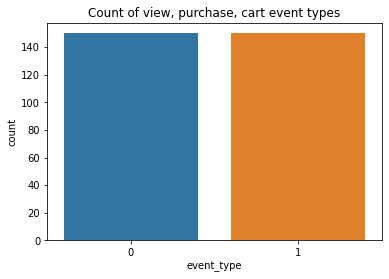

In [ ]:
##Count of event types
plt.title('Count of view, purchase, cart event types')
sns.countplot(x = 'event_type', data = sampled)

In [ ]:
sampled.head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,transaction_time,transaction_date
24097,2019-10-01 03:00:00,1,1004211,2053013555631882655,electronics.smartphone,samsung,97.79,550679725,bf8afaeb-5a57-47f0-b769-4082a4f84562,03:00:00,2019-10-01
21335,2019-10-01 02:56:04,1,1005104,2053013555631882655,electronics.smartphone,apple,975.57,555160488,786b7395-2ff2-4303-8f14-4ce89550b304,02:56:04,2019-10-01
4051,2019-10-01 02:26:11,1,6800659,2053013554222596431,computers.components.hdd,kingston,66.67,523117953,629a0485-36c9-4a80-9f02-4a96382c3059,02:26:11,2019-10-01


# **HPO**
Hyper-parameter tuning is just an optimization loop on top of ML model learning to find the set of hyper-parameters leading to the lowest error on the validation set.
### **sklearn.neural_network.MLPClassifier**
This model optimizes the log-loss function using LBFGS or stochastic gradient descent.




In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [ ]:
##Preparing the data for classification and initializing a data frame to store results
X = sampled[['user_id','product_id','price']]
y = sampled[['event_type']]
df_compare_1 = pd.DataFrame(columns=['alpha','max_iter', 'early_stopping','score'])

###**Testing the hyperparamer search manually**

In [ ]:
##Defining a function 'mlpClassifier' for run the classification with different hyperparameters
from sklearn.preprocessing import StandardScaler
def mlpClassifier(custom_alpha, custom_max_iter, custom_early_stopping, X, y, df_compare_1):
  model = MLPClassifier(alpha=custom_alpha, max_iter=custom_max_iter, early_stopping=custom_early_stopping)
  X = StandardScaler().fit_transform(X)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
  model.fit(X_train, y_train)
  score = 100.0 * model.score(X_test, y_test)
  df_compare_1.loc[-1] = [custom_alpha, custom_max_iter, custom_early_stopping, score]  # adding a row
  df_compare_1.index = df_compare_1.index + 1  # shifting index
  df_compare_1 = df_compare_1.sort_index()
  df_compare_1.reset_index(drop=True)

In [ ]:
##Checking with Early stopping set to False
##Increasing alpha while keeping max_iter constant
mlpClassifier(1, 1000, True, X, y, df_compare_1)
mlpClassifier(2, 1000, True, X, y, df_compare_1)
mlpClassifier(3, 1000, True, X, y, df_compare_1)
mlpClassifier(4, 1000, True, X, y, df_compare_1)
##Increasing max_iter while keeping alpha constant
mlpClassifier(1, 2000, True, X, y, df_compare_1)
mlpClassifier(1, 3000, True, X, y, df_compare_1)
mlpClassifier(1, 500, True, X, y, df_compare_1)
##Changing both alpha and max_iter
mlpClassifier(2, 100, True, X, y, df_compare_1)

# Repeat With Early stopping set to True
##Increasing alpha while keeping max_iter constant
mlpClassifier(1, 1000, False, X, y, df_compare_1)
mlpClassifier(2, 1000, False, X, y, df_compare_1)
mlpClassifier(3, 1000, False, X, y, df_compare_1)
mlpClassifier(4, 1000, False, X, y, df_compare_1)
##Increasing max_iter while keeping alpha constant
mlpClassifier(1, 2000, False, X, y, df_compare_1)
mlpClassifier(1, 3000, False, X, y, df_compare_1)
mlpClassifier(1, 500, False, X, y, df_compare_1)
##Changing both alpha and max_iter
mlpClassifier(2, 100, False, X, y, df_compare_1)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d

In [ ]:
##Displaying the results in a table
df_compare_1

,alpha,max_iter,early_stopping,score
15,1,1000,True,56.666667
14,2,1000,True,48.333333
13,3,1000,True,55.000000
12,4,1000,True,60.000000
11,1,2000,True,51.666667
10,1,3000,True,55.000000
9,1,500,True,66.666667
8,2,100,True,50.000000
7,1,1000,False,55.000000
6,2,1000,False,56.666667


### **Inference:**


1.   With early_stopping as 'True', the highest accuracy we see is 66% and with early_stopping as 'False', the highest accuracy we see is 76.6%
2.   Keeping the max_iter fixed(1000), if we increase the value of alpha(1 to 4), we see the accuracy is highest for the highest value of alpha.
3.   Keeping the alpha fixed(1), if we vary the value of max_iter, we see the accuracy is highest for the lowest value of max_iter.
4.   **NOTE**: These values are changing with every fresh execution of the model classification.



### **Using GridSearch**

In [ ]:
mlp = MLPClassifier()
parameter_space = {
    'alpha': [0.0001, 0.05],
    'max_iter': [1000,500],
    'early_stopping': [True, False]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'

In [ ]:
results = pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

In [ ]:
results

,alpha,early_stopping,max_iter,Accuracy
0,0.0001,True,1000,0.525000
1,0.0001,True,500,0.566667
2,0.0001,False,1000,0.504167
3,0.0001,False,500,0.545833
4,0.0500,True,1000,0.516667
5,0.0500,True,500,0.545833
6,0.0500,False,1000,0.525000
7,0.0500,False,500,0.562500


Alpha values = 0.05 and max_iter = 500 with early_stopping = True gives the best accuracy of 54%

# **Muller Loop before amalgamation**

In [ ]:
#Importing required libraries
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [ ]:
##Initializing a df for comparing muller loop results
df_compare_muller = pd.DataFrame(columns=['Classifier','Accuracy/Score', 'Training Time'])

In [ ]:
import time as time
import xgboost as xgb

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "XGBoost",
         "MLP"]

classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    xgb.XGBClassifier(max_depth=5, learning_rate=0.1,n_jobs=-1),
    MLPClassifier()]

X = sampled[['user_id','product_id','price']]
y = sampled[['event_type']]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

max_score = 0.0
max_class = ''
# iterate over classifiers
for name, clf in zip(names, classifiers):
    start_time = time.time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))
    training_time = time.time() - start_time
    df_compare_muller.loc[-1] = [name, score, training_time]  # adding a row
    df_compare_muller.index = df_compare_muller.index + 1  # shifting index
    df_compare_muller = df_compare_muller.sort_index()
    df_compare_muller.reset_index(drop=True)

    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
#plot the output of the various algorithms

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tr

Classifier = Nearest Neighbors, Score (test, accuracy) = 48.33, Training time = 0.01 seconds
Classifier = Linear SVM, Score (test, accuracy) = 55.00, Training time = 0.00 seconds
Classifier = RBF SVM, Score (test, accuracy) = 58.33, Training time = 0.00 seconds


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classifier = Gaussian Process, Score (test, accuracy) = 46.67, Training time = 0.82 seconds
Classifier = Decision Tree, Score (test, accuracy) = 50.00, Training time = 0.00 seconds
Classifier = Random Forest, Score (test, accuracy) = 56.67, Training time = 0.03 seconds
Classifier = Neural Net, Score (test, accuracy) = 56.67, Training time = 0.30 seconds
Classifier = AdaBoost, Score (test, accuracy) = 55.00, Training time = 0.12 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 53.33, Training time = 0.00 seconds
Classifier = QDA, Score (test, accuracy) = 60.00, Training time = 0.00 seconds
Classifier = XGBoost, Score (test, accuracy) = 56.67, Training time = 0.03 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Classifier = MLP, Score (test, accuracy) = 60.00, Training time = 0.38 seconds
--------------------------------------------------------------------------------
Best --> Classifier = QDA, Score (test, accuracy) = 60.00


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
df_compare_muller

,Classifier,Accuracy/Score,Training Time
0,MLP,60.000000,0.380464
1,XGBoost,56.666667,0.027129
2,QDA,60.000000,0.001814
3,Naive Bayes,53.333333,0.001845
4,AdaBoost,55.000000,0.115844
5,Neural Net,56.666667,0.297516
6,Random Forest,56.666667,0.026505
7,Decision Tree,50.000000,0.003979
8,Gaussian Process,46.666667,0.815293
9,RBF SVM,58.333333,0.004492


From the above comparison table, we see that MLP is the best classifier on our usecase with accuracy score of 60%.

# **AutoML**
Using Autogluon - a deep learning AutoML
Autogluon is a new open source AutoML library that automates deep learning (DL) and machine learning (ML) for real world applications involving image, text and tabular datasets

In [ ]:
##Importing required library and specifying task of interest
from autogluon.tabular import TabularPrediction as task

In [ ]:
##Commenting since we are using the existing dataset so as to compare with previous results
# train_path = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vT71NkW1z725FdPzaZ2wWumglSyeOh1PUUcHZ9t1s2zaUrc5gm7pRXmss9AXC-o7sirXrAK4Bd6kH6l/pub?gid=656397096&single=true&output=csv'
# train_data = task.Dataset(file_path=train_path)

In [ ]:
sampled.head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,transaction_time,transaction_date
24097,2019-10-01 03:00:00,1,1004211,2053013555631882655,electronics.smartphone,samsung,97.79,550679725,bf8afaeb-5a57-47f0-b769-4082a4f84562,03:00:00,2019-10-01
21335,2019-10-01 02:56:04,1,1005104,2053013555631882655,electronics.smartphone,apple,975.57,555160488,786b7395-2ff2-4303-8f14-4ce89550b304,02:56:04,2019-10-01
4051,2019-10-01 02:26:11,1,6800659,2053013554222596431,computers.components.hdd,kingston,66.67,523117953,629a0485-36c9-4a80-9f02-4a96382c3059,02:26:11,2019-10-01


In [ ]:
##Assigning to a different dataframe for ease of usage
train_data = sampled

In [ ]:
##Splitting the dataset into train and test to feed into AutoML
train_data_1, test_data_1 = train_test_split(train_data, test_size = 0.2)

In [ ]:
##Training the model on the above trained data by calling the fit() method
predictor = task.fit(train_data=train_data_1, label='event_type', output_directory='ag-example-out/')

Beginning AutoGluon training ...
AutoGluon will save models to ag-example-out/
AutoGluon Version:  0.0.16b20201214
Train Data Rows:    240
Train Data Columns: 10
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12420.75 MB
	Train Data (Original)  Memory Usage: 0.08 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stage 2 Generators:
	

In [ ]:
##Testing the trained model on test data using predict() method
predictor = task.load('ag-example-out/')
test_data_nolabel = test_data_1.drop(labels=['event_type'],axis=1)
y_pred = predictor.predict(test_data_nolabel)
y_pred_proba = predictor.predict_proba(test_data_nolabel)

In [ ]:
##Checking the results
leaderboard = predictor.leaderboard(test_data_1)

                  model  score_test  score_val  pred_time_test  pred_time_val  fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0               XGBoost    0.666667   0.583333        0.013297       0.008875  0.644581                 0.013297                0.008875           0.644581            0       True         10
1              CatBoost    0.650000   0.625000        0.006740       0.006824  0.626528                 0.006740                0.006824           0.626528            0       True          9
2              LightGBM    0.650000   0.645833        0.014795       0.011188  0.243444                 0.014795                0.011188           0.243444            0       True          7
3        KNeighborsUnif    0.650000   0.562500        0.103938       0.105271  0.004800                 0.103938                0.105271           0.004800            0       True          5
4            LightGBMXT    0.600000   0.66666

From the leaderboard, we see NeuralNetMXNet is the best classifier on our usecase with accuracy score of 65%. </br>
**From the above comparisons, below are the consolidated results:**


1.   HPO on MLP classifier by varying the hyperparameters: alpha = 2, max_iter = 1000, early_stopping = False

2.   Running a muller loop on the same usecase gives: Random Forest is the best classifier on our usecase with accuracy score of 58%

3.   Using AutoML - Autogluon: we see XGBoost is the best classifier on our usecase with accuracy score of 66%



# **AMALGAMATION**
Using Mall customer dataset:
https://www.kaggle.com/shwetabh123/mall-customers </br>
Amalgamating based on spending score column.</br>
Step 1: To calculate spending score in original dataset </br>
Step 2: Merge with mall_customer dataset on spending score

In [ ]:
##Importing the mall customer dataset
r = requests.get('https://docs.google.com/spreadsheets/d/e/2PACX-1vT0HMaqAgd7d_EyMRByWkVp8JM7jmp_969OPyfDMsk4pHpdWjPeQQePP0Rrfm4bwWxQVh7lJPPZHJvi/pub?gid=0&single=true&output=csv')
data = r.content
df_Mall = pd.read_csv(BytesIO(data))

In [ ]:
df_Mall.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [ ]:
## We are calculating the total amount spent by each customer on electronice data.
df1 = df_Oct.groupby(['user_id']).agg({'price': 'sum'}).reset_index()

In [ ]:
df1.columns = ['user_id','total_spending']
df1.head(3)

,user_id,total_spending
0,306441847,329.42
1,362699320,889.29
2,372944259,686.76


In [ ]:
#Join the df_Oct df with the df1 df 
df_Oct = df_Oct.merge(df1,on='user_id')

In [ ]:
##Calculating spending score to merge with mall customer dataset: Scaling down column 'total_spending'
df_Oct['Spending_Score'] = pd.qcut(df_Oct['total_spending'], q=100, labels=False)

In [ ]:
df_Oct.head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,transaction_time,transaction_date,total_spending,Spending_Score
0,2019-10-01 00:00:00,0,44600062,2103807459595387724,Not Available,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,00:00:00,2019-10-01,71.58,3
1,2019-10-01 00:00:15,0,44600062,2103807459595387724,Not Available,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,00:00:15,2019-10-01,71.58,3
2,2019-10-01 00:00:00,0,3900821,2053013552326770905,appliances.environment.water_heater,aqua,33.20,554748717,9333dfbd-b87a-4708-9857-6336556b0fcc,00:00:00,2019-10-01,277.56,14


In [ ]:
df_Mall = df_Mall.drop(columns=['CustomerID','Annual Income (k$)'])

In [ ]:
df_Mall.columns = ['Gender','Age','Spending_Score']
df_Mall.head(3)

,Gender,Age,Spending_Score
0,Male,19,39
1,Male,21,81
2,Female,20,6


In [ ]:
amalgamated_df = df_Oct.merge(df_Mall,on='Spending_Score')
amalgamated_df.head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,transaction_time,transaction_date,total_spending,Spending_Score,Gender,Age
0,2019-10-01 00:00:00,0,44600062,2103807459595387724,Not Available,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,00:00:00,2019-10-01,71.58,3,Male,64
1,2019-10-01 00:00:15,0,44600062,2103807459595387724,Not Available,shiseido,35.79,541312140,72d76fde-8bb3-4e00-8c23-a032dfed738c,00:00:15,2019-10-01,71.58,3,Male,64
2,2019-10-01 00:00:20,0,4803399,2053013554658804075,electronics.audio.headphone,jbl,33.21,555428858,8a6afed4-77f8-40c9-8e76-e062b28216ce,00:00:20,2019-10-01,66.42,3,Male,64


# **Preparation for running classification after amalgamation**

In [ ]:
##creating two dataframes with purchased users and non purchased users to balance the data
amalgamated_purchased_set = amalgamated_df[amalgamated_df['event_type']==1]
amalgamated_non_purchased_set = amalgamated_df[amalgamated_df['event_type']==0]

In [ ]:
from sklearn.utils import resample
##equally sampling 150 data points from each type
n_samples = 150
amalgamated_puchased_sampled = resample(amalgamated_purchased_set, replace=False, n_samples=n_samples, random_state=27)
amalgamated_not_purchased_sampled = resample(amalgamated_non_purchased_set, replace=False, n_samples=n_samples, random_state=27)

In [ ]:
##creating a dataframe sampled by concatenating purchased and not purchased sampled dataframes
amalgamated_sampled = pd.concat([amalgamated_puchased_sampled, amalgamated_not_purchased_sampled])
amalgamated_sampled['event_type'].value_counts()

1    150
0    150
Name: event_type, dtype: int64

# **HPO on amalgamated dataset**

In [ ]:
amalgamated_sampled.head(3)

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,transaction_time,transaction_date,total_spending,Spending_Score,Gender,Age
21573,2019-10-01 03:23:35,1,5100833,2053013553375346967,Not Available,xiaomi,48.56,531569958,beea2e85-f7e8-49c9-94f9-55c1ff95e897,03:23:35,2019-10-01,97.12,5,Female,57
75422,2019-10-01 03:04:05,1,1004767,2053013555631882655,electronics.smartphone,samsung,254.76,516124288,2d9b2866-171d-4c06-8163-36a4772d2cc6,03:04:05,2019-10-01,3950.99,75,Female,36
21913,2019-10-01 03:30:16,1,4804295,2053013554658804075,electronics.audio.headphone,xiaomi,22.39,541637343,c5655fec-e679-4637-a46d-4270734c2c07,03:30:16,2019-10-01,111.95,5,Female,57


In [ ]:
##Preparing the data for classification and initializing a data frame to store results
X = amalgamated_sampled[['user_id','product_id','price','Spending_Score','Age']]
y = amalgamated_sampled[['event_type']]
df_compare_2 = pd.DataFrame(columns=['alpha','max_iter', 'early_stopping','score'])

In [ ]:
##Checking with Early stopping set to False
##Increasing alpha while keeping max_iter constant
mlpClassifier(1, 1000, True, X, y, df_compare_2)
mlpClassifier(2, 1000, True, X, y, df_compare_2)
mlpClassifier(3, 1000, True, X, y, df_compare_2)
mlpClassifier(4, 1000, True, X, y, df_compare_2)
##Increasing max_iter while keeping alpha constant
mlpClassifier(1, 2000, True, X, y, df_compare_2)
mlpClassifier(1, 3000, True, X, y, df_compare_2)
mlpClassifier(1, 500, True, X, y, df_compare_2)
##Changing both alpha and max_iter
mlpClassifier(2, 100, True, X, y, df_compare_2)

# Repeat With Early stopping set to True
##Increasing alpha while keeping max_iter constant
mlpClassifier(1, 1000, False, X, y, df_compare_2)
mlpClassifier(2, 1000, False, X, y, df_compare_2)
mlpClassifier(3, 1000, False, X, y, df_compare_2)
mlpClassifier(4, 1000, False, X, y, df_compare_2)
##Increasing max_iter while keeping alpha constant
mlpClassifier(1, 2000, False, X, y, df_compare_2)
mlpClassifier(1, 3000, False, X, y, df_compare_2)
mlpClassifier(1, 500, False, X, y, df_compare_2)
##Changing both alpha and max_iter
mlpClassifier(2, 100, False, X, y, df_compare_2)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d

In [ ]:
df_compare_2

,alpha,max_iter,early_stopping,score
15,1,1000,True,60.000000
14,2,1000,True,58.333333
13,3,1000,True,60.000000
12,4,1000,True,65.000000
11,1,2000,True,50.000000
10,1,3000,True,50.000000
9,1,500,True,48.333333
8,2,100,True,43.333333
7,1,1000,False,58.333333
6,2,1000,False,55.000000


### **Using gridSearch**

In [ ]:
from sklearn.model_selection import GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'

In [ ]:
results = pd.concat([pd.DataFrame(clf.cv_results_["params"]),pd.DataFrame(clf.cv_results_["mean_test_score"], columns=["Accuracy"])],axis=1)

In [ ]:
results

,alpha,early_stopping,max_iter,Accuracy
0,0.0001,True,1000,0.504167
1,0.0001,True,500,0.495833
2,0.0001,False,1000,0.495833
3,0.0001,False,500,0.487500
4,0.0500,True,1000,0.483333
5,0.0500,True,500,0.450000
6,0.0500,False,1000,0.479167
7,0.0500,False,500,0.516667


Alpha values = 0.05 and max_iter = 500 with early_stopping = False gives the best accuracy of 51%

# **Running a muller loop**

In [ ]:
df_compare_muller = pd.DataFrame(columns=['Classifier','Accuracy/Score', 'Training Time'])

In [ ]:
import time as time

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA",# "XGBoost",
         "MLP"]

classifiers = [
    KNeighborsClassifier(2),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    MLPClassifier()]

X = amalgamated_sampled[['user_id','product_id','price','Spending_Score','Age']]
y = amalgamated_sampled[['event_type']]
X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

max_score = 0.0
max_class = ''
# iterate over classifiers
for name, clf in zip(names, classifiers):
    start_time = time.time()
    clf.fit(X_train, y_train)
    score = 100.0 * clf.score(X_test, y_test)
    print('Classifier = %s, Score (test, accuracy) = %.2f,' %(name, score), 'Training time = %.2f seconds' % (time.time() - start_time))
    training_time = time.time() - start_time
    df_compare_muller.loc[-1] = [name, score, training_time]  # adding a row
    df_compare_muller.index = df_compare_muller.index + 1  # shifting index
    df_compare_muller = df_compare_muller.sort_index()
    df_compare_muller.reset_index(drop=True)

    if score > max_score:
        clf_best = clf
        max_score = score
        max_class = name

print(80*'-' )
print('Best --> Classifier = %s, Score (test, accuracy) = %.2f' %(max_class, max_score))
#plot the output of the various algorithms

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=Tr

Classifier = Nearest Neighbors, Score (test, accuracy) = 46.67, Training time = 0.00 seconds
Classifier = Linear SVM, Score (test, accuracy) = 51.67, Training time = 0.00 seconds
Classifier = RBF SVM, Score (test, accuracy) = 45.00, Training time = 0.00 seconds


/usr/local/lib/python3.7/dist-packages/scipy/optimize/lbfgsb.py:360: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  task_str = task.tostring().strip(b'\x00').strip()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classifier = Gaussian Process, Score (test, accuracy) = 53.33, Training time = 0.42 seconds
Classifier = Decision Tree, Score (test, accuracy) = 60.00, Training time = 0.00 seconds
Classifier = Random Forest, Score (test, accuracy) = 50.00, Training time = 0.05 seconds
Classifier = Neural Net, Score (test, accuracy) = 56.67, Training time = 0.34 seconds
Classifier = AdaBoost, Score (test, accuracy) = 58.33, Training time = 0.12 seconds
Classifier = Naive Bayes, Score (test, accuracy) = 53.33, Training time = 0.00 seconds
Classifier = QDA, Score (test, accuracy) = 51.67, Training time = 0.00 seconds


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:934: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Classifier = MLP, Score (test, accuracy) = 55.00, Training time = 0.41 seconds
--------------------------------------------------------------------------------
Best --> Classifier = Decision Tree, Score (test, accuracy) = 60.00


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [ ]:
df_compare_muller

,Classifier,Accuracy/Score,Training Time
0,MLP,55.000000,0.415429
1,QDA,51.666667,0.001620
2,Naive Bayes,53.333333,0.001603
3,AdaBoost,58.333333,0.118370
4,Neural Net,56.666667,0.345541
5,Random Forest,50.000000,0.057656
6,Decision Tree,60.000000,0.004086
7,Gaussian Process,53.333333,0.423321
8,RBF SVM,45.000000,0.004415
9,Linear SVM,51.666667,0.002515
